In [1]:
%load_ext autoreload
%autoreload 2

# load environment variables
import os
from dotenv import load_dotenv, find_dotenv
dotenv_path = find_dotenv()
load_dotenv(dotenv_path)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sqlalchemy import create_engine

from src.functions.io import ModuleFileReader
from src import queries
scripts = ModuleFileReader(queries)

In [2]:
engine = create_engine(os.environ.get("DATABASE_URL"))

## Seasonality Analysis

In [3]:
films_w_genres = pd.read_sql_query(scripts.read("films_join_hot_genres.sql"), engine)
films_w_genres.set_index(pd.DatetimeIndex(films_w_genres.released), inplace=True)
films_w_genres.head()

,id,title,released,runtime,rated,budget,total_gross,award_noms,award_wins,oscar_noms,...,sci-fi,biography,fantasy,animation,adventure,family,sport,western,documentary,musical
released,,,,,,,,,,,,,,,,,,,,,
2018-01-05,1,Insidious: The Last Key,2018-01-05,103,PG-13,10000000.0,167885588.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-01-12,5,The Commuter,2018-01-12,105,PG-13,40000000.0,200900000.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-01-12,6,Proud Mary,2018-01-12,89,R,14000000.0,21800000.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-01-12,8,Freak Show,2018-01-12,91,N/A,2000000.0,18216.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-01-19,12,12 Strong,2018-01-19,130,R,35000000.0,70800000.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Looking at horror first:

In [4]:
films2010plus = films_w_genres[films_w_genres.index.year > 2009]

In [5]:
years = sorted(list(films2010plus.index.year.unique()))
years

[2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]

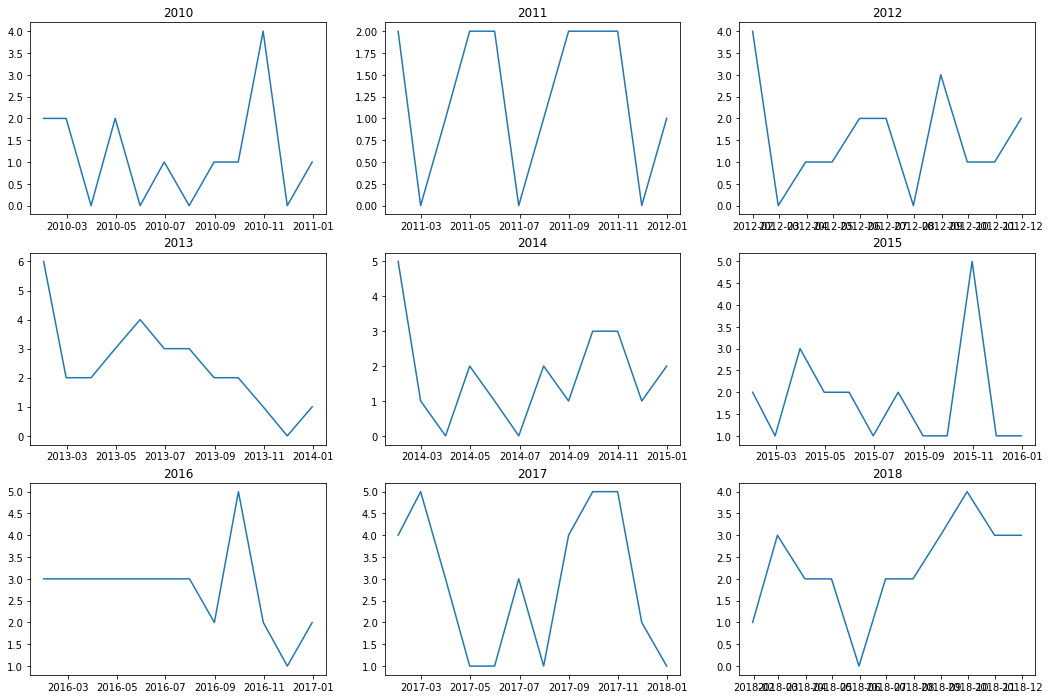

In [6]:
plt.figure(figsize=(18,12))
for ix, year in enumerate(years):
    plt.subplot(3,3,ix + 1)
    films_that_year = films2010plus[films2010plus.index.year == year]
    horror_films = films_that_year[films_that_year.horror == 1]
    monthly = horror_films.resample('M').count()['title']
    plt.plot(monthly.index, monthly.values)
    plt.title(str(year))

- Trend near the end of the year, september/october/november
- 2011 had very few horror films

In [7]:
holidays = pd.read_sql_query(scripts.read('holidays.sql'), engine)
holidays.set_index(pd.DatetimeIndex(holidays.date), inplace=True)
holidays.drop('date', axis=1, inplace=True)

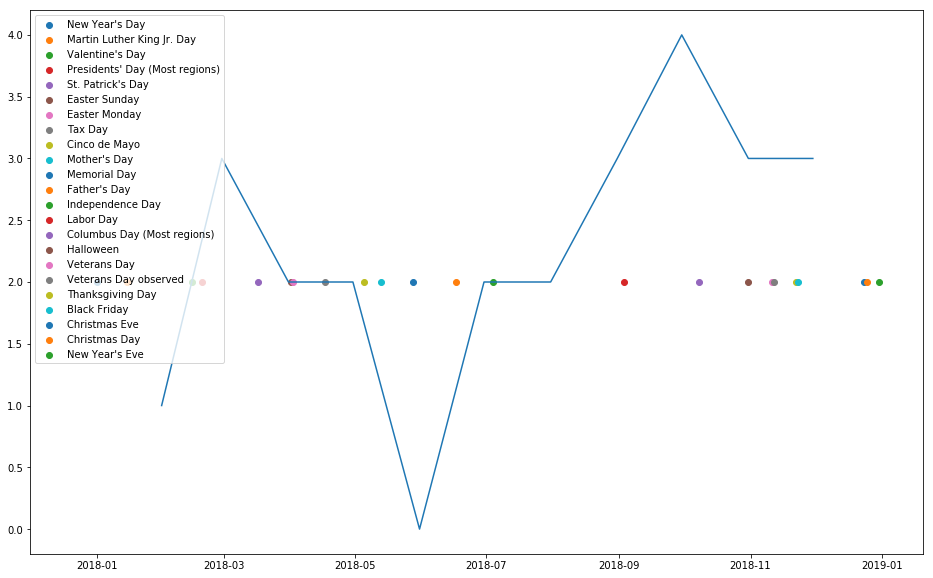

In [8]:
plt.figure(figsize=(16,10))

films2018 = films2010plus[films2010plus.index.year == 2018]
horror_films = films2018[films2018.horror == 1]
monthly = horror_films.resample('M').count()['title']

holidays2018 = holidays[holidays.index.year == 2018]
for ix, holiday in zip(holidays2018.index, holidays2018.holiday):
    plt.scatter(ix, 2, label=holiday)

plt.plot(monthly.index, monthly.values)
plt.legend()

seasonality for film releases in general

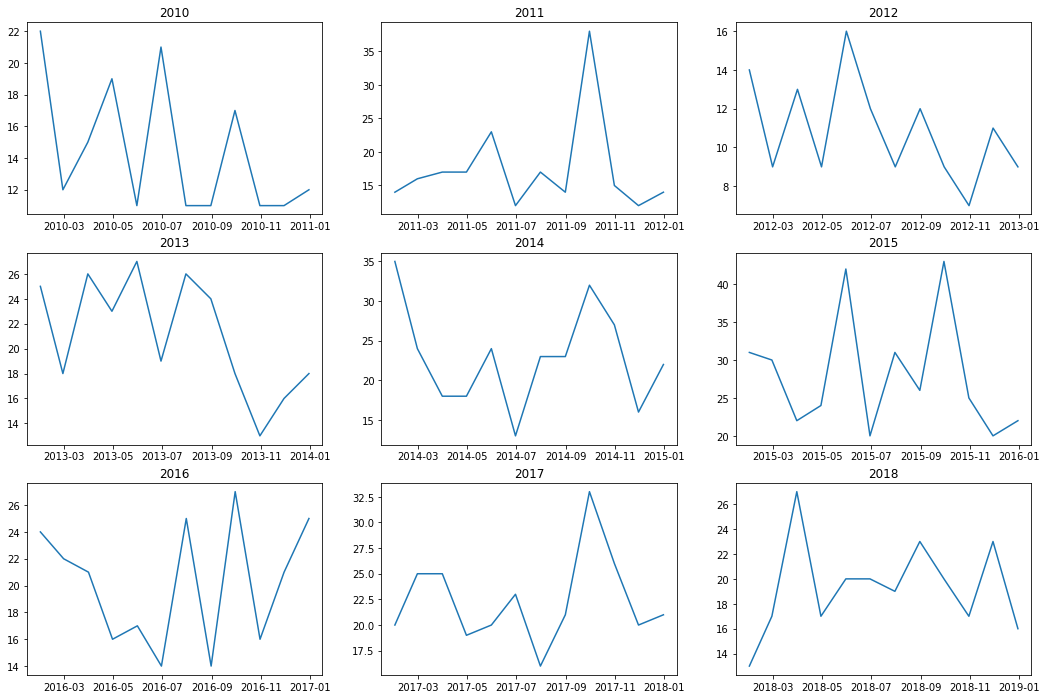

In [9]:
plt.figure(figsize=(18,12))
for i,x in enumerate(years):
    plt.subplot(3,3,i + 1)
    films_that_year = films2010plus[films2010plus.index.year == x]
    monthly = films_that_year.resample('M').count()['title']
    plt.plot(monthly.index, monthly.values)
    plt.title(str(x))

- November seems to be a pretty dry month for movies across most years, except for 2014
- No clear pattern of general seasonality however, summer months aren't always huge release periods as thought

## Normalized horror films per year

In [170]:
horror_films = films2010plus[films2010plus.horror == 1]

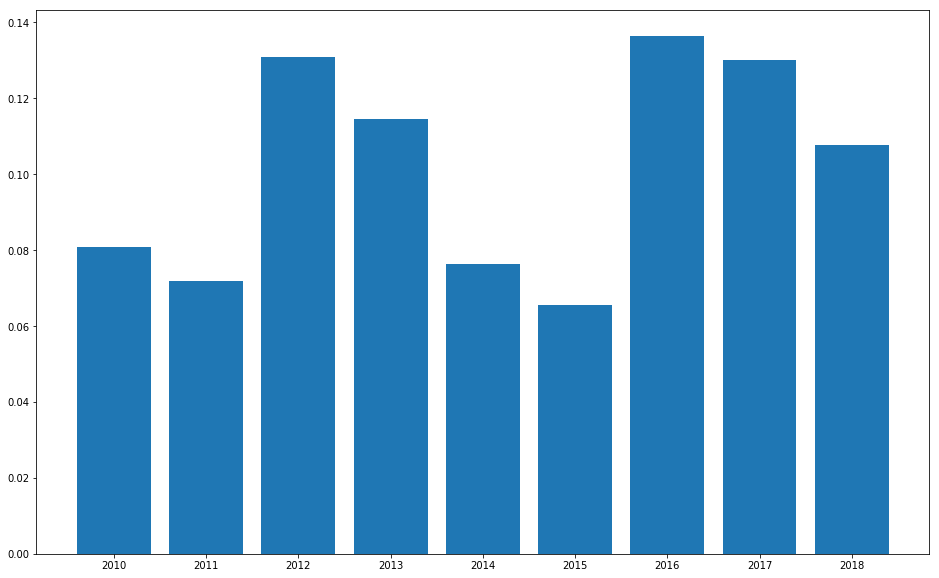

In [169]:
plt.figure(figsize=(16,10))
horror_films_per_year = horror_films.groupby(horror_films.index.year).count()['title']
total_films_per_year = films2010plus.groupby(films2010plus.index.year).count()['title']
norm_horror_per_year = horror_films_per_year / total_films_per_year
plt.bar(norm_horror_per_year.index, norm_horror_per_year.values)
plt.xticks(years)
plt.show()

- At most, horror seems to represent ~10% of total films released each year.
- Between 7-10%

## Normalized total grosses for Horror Films

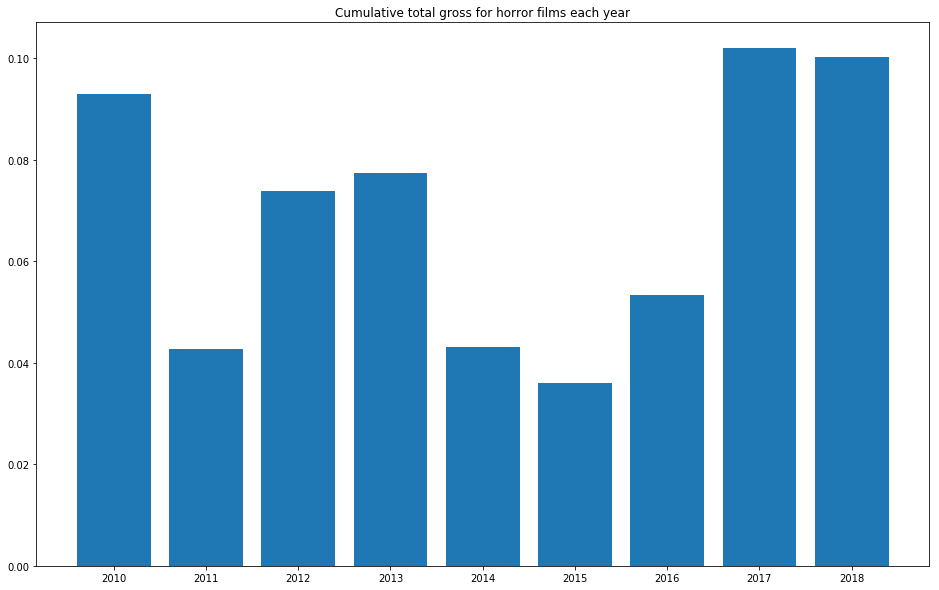

In [172]:
horror_total_grosses = horror_films.groupby(horror_films.index.year).sum()['total_gross']
total_year_grosses = films2010plus.groupby(films2010plus.index.year).sum()['total_gross']
normalized_horror_grosses = horror_total_grosses/total_year_grosses

plt.figure(figsize=(16,10))
plt.bar(normalized_horror_grosses.index, normalized_horror_grosses.values)
plt.xticks(years)
plt.title("Cumulative total gross for horror films each year")
plt.show()

## Genre Metrics Breakdown

Success criteria: budget, awards, ratings, total gross, ROI, windows, opening weekend

In [92]:
# to get rid of scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [120]:
genre_metrics = pd.read_sql_query(scripts.read("genre_metrics.sql"), engine)

In [136]:
genre_means = genre_metrics.groupby(genre_metrics.genre).mean()
genre_medians = genre_metrics.groupby(genre_metrics.genre).median()
genre_max = genre_metrics.groupby(genre_metrics.genre).max()
genre_min = genre_metrics.groupby(genre_metrics.genre).min()

In [124]:
genre_means.columns

Index(['id', 'runtime', 'budget', 'total_gross', 'award_noms', 'award_wins',
       'oscar_noms', 'oscar_wins', 'ratings_imdb', 'ratings_meta',
       'ratings_tomatoes', 'domestic_gross', 'foreign_gross', 'domestic_pct',
       'foreign_pct', 'roi'],
      dtype='object')

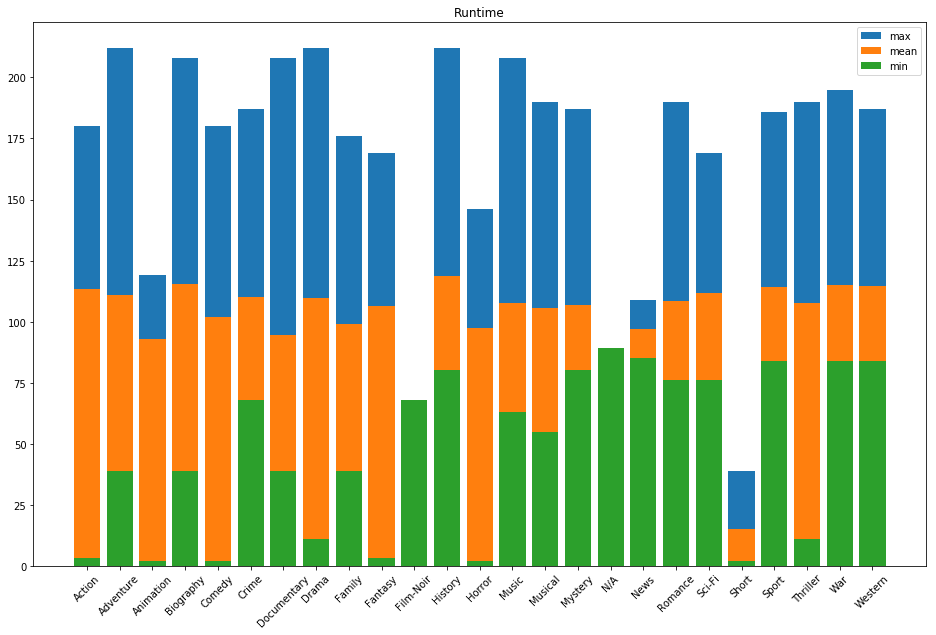

In [138]:
plt.figure(figsize=(16,10))

plt.bar(genre_means.index, genre_max.runtime, label='max')
plt.bar(genre_means.index, genre_means.runtime, label='mean')
plt.bar(genre_means.index, genre_min.runtime, label='min')
plt.xticks(rotation=45)
plt.title('Runtime')
plt.legend()
plt.show()

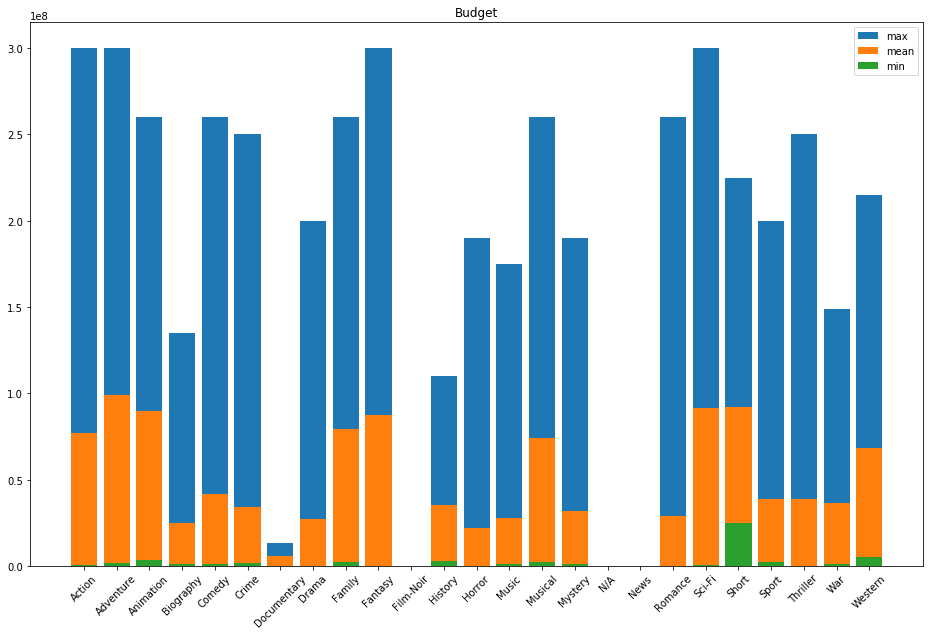

In [139]:
plt.figure(figsize=(16,10))

plt.bar(genre_means.index, genre_max.budget, label='max')
plt.bar(genre_means.index, genre_means.budget, label='mean')
plt.bar(genre_means.index, genre_min.budget, label='min')
plt.xticks(rotation=45)
plt.title('Budget')
plt.legend()
plt.show()

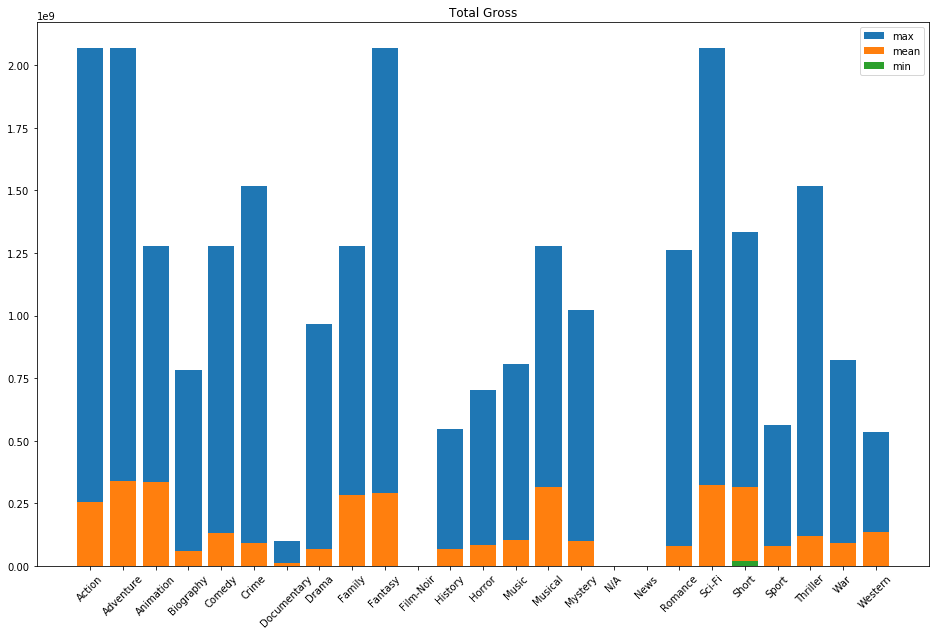

In [146]:
plt.figure(figsize=(16,10))

plt.bar(genre_means.index, genre_max.total_gross, label='max')
plt.bar(genre_means.index, genre_means.total_gross, label='mean')
#plt.bar(genre_means.index, genre_medians.total_gross, label='median')
plt.bar(genre_means.index, genre_min.total_gross, label='min')
plt.xticks(rotation=45)
plt.title('Total Gross')
plt.legend()
plt.show()

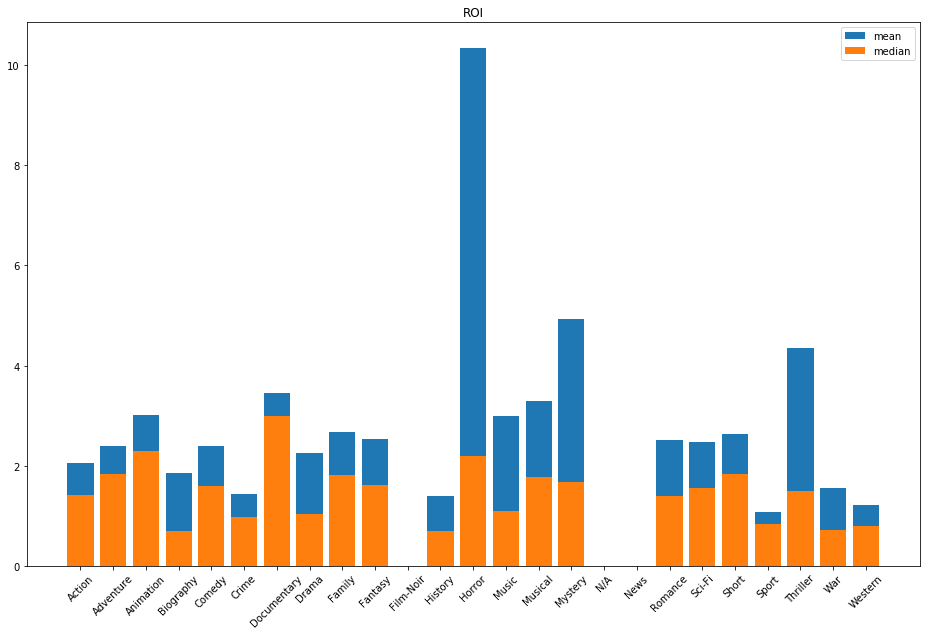

In [147]:
plt.figure(figsize=(16,10))

plt.bar(genre_means.index, genre_means.roi, label='mean')
plt.bar(genre_medians.index, genre_medians.roi, label='median')

plt.xticks(rotation=45)
plt.title('ROI')
plt.legend()
plt.show()

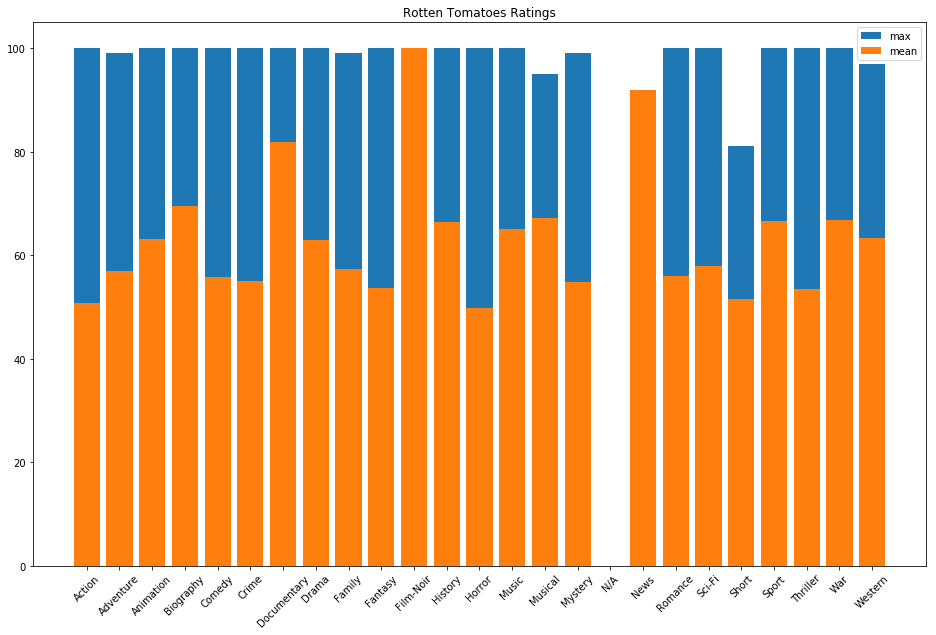

In [149]:
plt.figure(figsize=(16,10))

plt.bar(genre_means.index, genre_max.ratings_tomatoes, label='max')
plt.bar(genre_means.index, genre_means.ratings_tomatoes, label='mean')
#plt.bar(genre_means.index, genre_medians.total_gross, label='median')
#plt.bar(genre_means.index, genre_min.ratings_tomatoes, label='min')
plt.xticks(rotation=45)
plt.title('Rotten Tomatoes Ratings')
plt.legend()
plt.show()

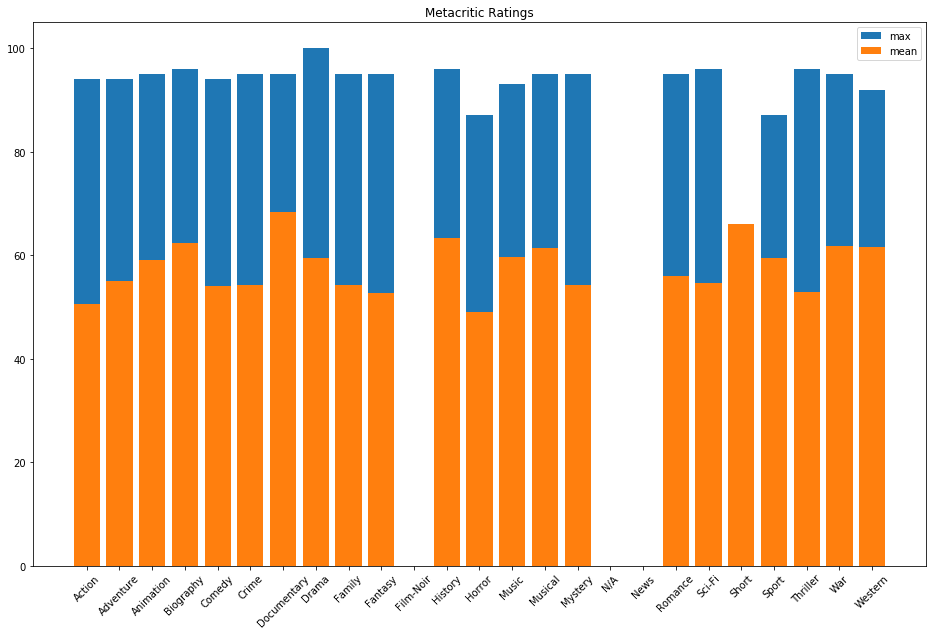

In [150]:
plt.figure(figsize=(16,10))

plt.bar(genre_means.index, genre_max.ratings_meta, label='max')
plt.bar(genre_means.index, genre_means.ratings_meta, label='mean')
#plt.bar(genre_means.index, genre_medians.total_gross, label='median')
#plt.bar(genre_means.index, genre_min.ratings_tomatoes, label='min')
plt.xticks(rotation=45)
plt.title('Metacritic Ratings')
plt.legend()
plt.show()

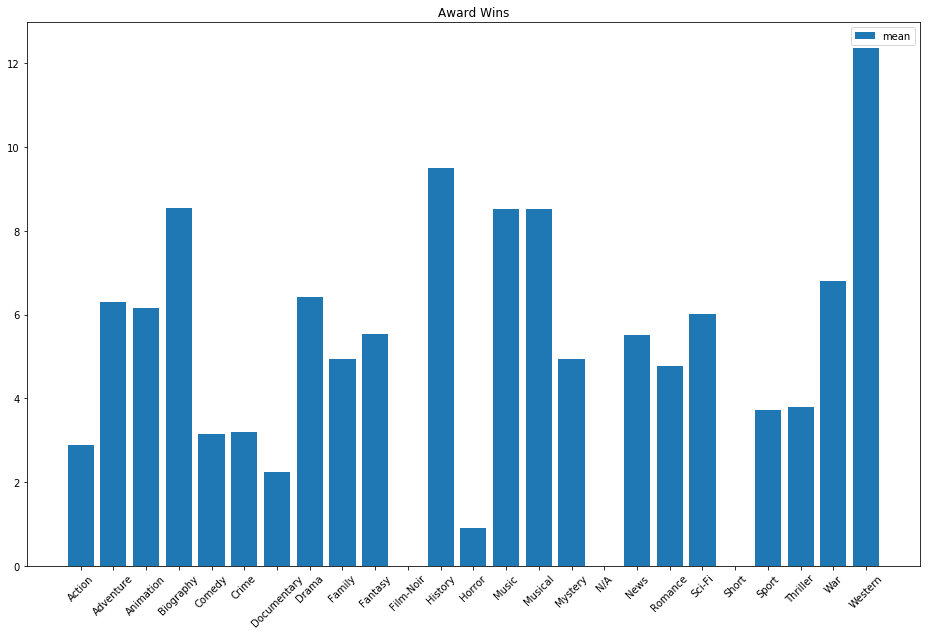

In [168]:
plt.figure(figsize=(16,10))

#plt.bar(genre_means.index, genre_max.award_wins, label='max')
plt.bar(genre_means.index, genre_means.award_wins, label='mean')
#plt.bar(genre_means.index, genre_medians.total_gross, label='median')
#plt.bar(genre_means.index, genre_min.ratings_tomatoes, label='min')
plt.xticks(rotation=45)
plt.title('Award Wins')
plt.legend()
plt.show()

## Do critic ratings affect success metrics for horror films as much as other films?

Look for correlations

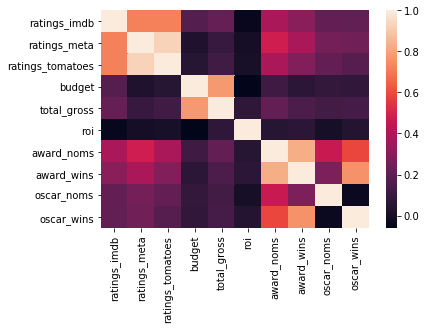

In [194]:
film_metrics = genre_metrics.groupby('title').mean()
critics_vs_metrics_cols = ['ratings_imdb', 'ratings_meta', 'ratings_tomatoes',
                           'budget', 'total_gross', 'roi', 'award_noms',
                           'award_wins','oscar_noms', 'oscar_wins']
critics_vs_metrics = film_metrics[critics_vs_metrics_cols]

sns.heatmap(critics_vs_metrics.corr())

In [195]:
critics_vs_metrics.corr()

,ratings_imdb,ratings_meta,ratings_tomatoes,budget,total_gross,roi,award_noms,award_wins,oscar_noms,oscar_wins
ratings_imdb,1.000,0.722,0.719,0.172,0.219,-0.041,0.386,0.305,0.213,0.208
ratings_meta,0.722,1.000,0.930,0.028,0.094,0.001,0.481,0.387,0.255,0.245
ratings_tomatoes,0.719,0.930,1.000,0.050,0.121,0.007,0.388,0.289,0.211,0.177
budget,0.172,0.028,0.050,1.000,0.777,-0.061,0.116,0.060,0.083,0.077
total_gross,0.219,0.094,0.121,0.777,1.000,0.072,0.211,0.151,0.128,0.132
roi,-0.041,0.001,0.007,-0.061,0.072,1.000,0.051,0.060,0.005,0.043
award_noms,0.386,0.481,0.388,0.116,0.211,0.051,1.000,0.833,0.465,0.592
award_wins,0.305,0.387,0.289,0.060,0.151,0.060,0.833,1.000,0.276,0.764
oscar_noms,0.213,0.255,0.211,0.083,0.128,0.005,0.465,0.276,1.000,-0.035
oscar_wins,0.208,0.245,0.177,0.077,0.132,0.043,0.592,0.764,-0.035,1.000


- In general, it doesn't seem like reviews have much of an impact on ROI or total gross
- IMDB ratings and award nominations seem to be the best indicators of total gross, but very weak
- A films budget is strongly correlated to its total gross, but this intuitively makes sense. More money invested means the film is of a higher calibur/bigger production and is expected to make more \$$$ back

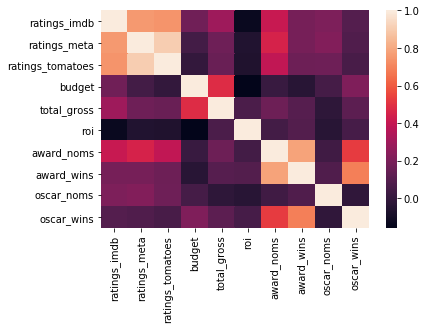

In [196]:
horror_metrics = genre_metrics[genre_metrics.genre == 'Horror']
horror_critics_vs_metrics = horror_metrics[critics_vs_metrics_cols]
sns.heatmap(horror_critics_vs_metrics.corr())

In [197]:
horror_critics_vs_metrics.corr()

,ratings_imdb,ratings_meta,ratings_tomatoes,budget,total_gross,roi,award_noms,award_wins,oscar_noms,oscar_wins
ratings_imdb,1.000,0.759,0.745,0.175,0.295,-0.129,0.408,0.194,0.209,0.098
ratings_meta,0.759,1.000,0.906,0.048,0.171,-0.057,0.454,0.192,0.224,0.084
ratings_tomatoes,0.745,0.906,1.000,-0.002,0.154,-0.061,0.392,0.164,0.167,0.059
budget,0.175,0.048,-0.002,1.000,0.487,-0.159,0.017,-0.036,0.050,0.214
total_gross,0.295,0.171,0.154,0.487,1.000,0.069,0.163,0.101,-0.016,0.119
roi,-0.129,-0.057,-0.061,-0.159,0.069,1.000,0.045,0.091,-0.035,0.055
award_noms,0.408,0.454,0.392,0.017,0.163,0.045,1.000,0.785,0.038,0.527
award_wins,0.194,0.192,0.164,-0.036,0.101,0.091,0.785,1.000,0.083,0.691
oscar_noms,0.209,0.224,0.167,0.050,-0.016,-0.035,0.038,0.083,1.000,-0.013
oscar_wins,0.098,0.084,0.059,0.214,0.119,0.055,0.527,0.691,-0.013,1.000


- imdb ratings matter 12% more than other review metrics, weak correlation to total gross
- budget is less indicative of a higher total gross in horror than in general, and has a slight negative corr to roi

**in general it seems that critic reviews don't have much of an impact on films' total gross or ROIs.**